# Ames, Iowa House Price Predictions

In [1472]:
# Importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler

In [1473]:
# Importing raw train and test files provided by Kaggle.

df_train = pd.read_csv("./Files/train.csv").set_index('Id')
df_test = pd.read_csv("./Files/test.csv").set_index('Id')

### General overview of the data

In [1474]:
# Table sample shows a lot of potential feature to use to predict target variable.

df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1475]:
# Interesting to note that train and test are a 50-50 split from the full data set. Test has one less column because price has been removed.

print("The size of train is {0}".format(df_train.shape))
print("The size of test is {0}".format(df_test.shape))

The size of train is (1460, 80)
The size of test is (1459, 79)


In [1476]:
# Some features will be removed because of too many NaN.

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [1477]:
# Converting MoSold, YrSold, YearBuilt, YearRemodAdd and MSSubClass to str as they don't have a numerical sense.

df_train['MoSold'] = df_train['MoSold'].astype(str)
df_test['MoSold'] = df_test['MoSold'].astype(str)

df_train['YrSold'] = df_train['YrSold'].astype(str)
df_test['YrSold'] = df_test['YrSold'].astype(str)

df_train['YearBuilt'] = df_train['YearBuilt'].astype(str)
df_test['YearBuilt'] = df_test['YearBuilt'].astype(str)

df_train['YearRemodAdd'] = df_train['YearRemodAdd'].astype(str)
df_test['YearRemodAdd'] = df_test['YearRemodAdd'].astype(str)

df_train['MSSubClass'] = df_train['MSSubClass'].astype(str)
df_test['MSSubClass'] = df_test['MSSubClass'].astype(str)

df_train['OverallQual'] = df_train['OverallQual'].astype(str)
df_test['OverallQual'] = df_test['OverallQual'].astype(str)

df_train['OverallCond'] = df_train['OverallCond'].astype(str)
df_test['OverallCond'] = df_test['OverallCond'].astype(str)

In [1478]:
df_train[df_train.select_dtypes(include=['object']).columns].nunique()

MSSubClass        15
MSZoning           5
Street             2
Alley              2
LotShape           4
LandContour        4
Utilities          2
LotConfig          5
LandSlope          3
Neighborhood      25
Condition1         9
Condition2         8
BldgType           5
HouseStyle         8
OverallQual       10
OverallCond        9
YearBuilt        112
YearRemodAdd      61
RoofStyle          6
RoofMatl           8
Exterior1st       15
Exterior2nd       16
MasVnrType         4
ExterQual          4
ExterCond          5
Foundation         6
BsmtQual           4
BsmtCond           4
BsmtExposure       4
BsmtFinType1       6
BsmtFinType2       6
Heating            6
HeatingQC          5
CentralAir         2
Electrical         5
KitchenQual        4
Functional         7
FireplaceQu        5
GarageType         6
GarageFinish       3
GarageQual         5
GarageCond         5
PavedDrive         3
PoolQC             3
Fence              4
MiscFeature        4
MoSold            12
YrSold       

In [1479]:
# Removing columns with too many NaN, too many unique values and too few unique values
# MSSubClass is dropped to having too few values in some categories.

df_train = df_train.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'YearBuilt', 'YearRemodAdd', 'MSSubClass'],axis=1)
df_test = df_test.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu', 'YearBuilt', 'YearRemodAdd', 'MSSubClass'],axis=1)

cat_cols = list(df_train.select_dtypes(include = ['object']))
cols_to_drop = df_train[cat_cols].nunique()[df_train[cat_cols].nunique() <= 7].index

df_train = df_train.drop(cols_to_drop,axis=1)
df_test = df_test.drop(cols_to_drop,axis=1)

In [1480]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1201 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   Neighborhood   1460 non-null   object 
 3   Condition1     1460 non-null   object 
 4   Condition2     1460 non-null   object 
 5   HouseStyle     1460 non-null   object 
 6   OverallQual    1460 non-null   object 
 7   OverallCond    1460 non-null   object 
 8   RoofMatl       1460 non-null   object 
 9   Exterior1st    1460 non-null   object 
 10  Exterior2nd    1460 non-null   object 
 11  MasVnrArea     1452 non-null   float64
 12  BsmtFinSF1     1460 non-null   int64  
 13  BsmtFinSF2     1460 non-null   int64  
 14  BsmtUnfSF      1460 non-null   int64  
 15  TotalBsmtSF    1460 non-null   int64  
 16  1stFlrSF       1460 non-null   int64  
 17  2ndFlrSF       1460 non-null   int64  
 18  LowQualF

In [1481]:
# Creating variables with categorical column names and numerical column names to simplify code.

cat_cols = list(df_train.select_dtypes(include = ['object']))
num_cols = list(df_train.select_dtypes(exclude = ['object']))

# There doesn't seem to be any categorical features with too many unique values. No major overfitting risk.

df_train[cat_cols].nunique()

Neighborhood    25
Condition1       9
Condition2       8
HouseStyle       8
OverallQual     10
OverallCond      9
RoofMatl         8
Exterior1st     15
Exterior2nd     16
MoSold          12
SaleType         9
dtype: int64

In [1482]:
# There aren't too many NaN in our datasets. LotFrontage has the most at 259. Not removing it for the time being.

print(df_train[cat_cols].isnull().sum())
print(df_train[num_cols].isnull().sum())


Neighborhood    0
Condition1      0
Condition2      0
HouseStyle      0
OverallQual     0
OverallCond     0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MoSold          0
SaleType        0
dtype: int64
LotFrontage      259
LotArea            0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
SalePrice          0
dtype: int64


<AxesSubplot: >

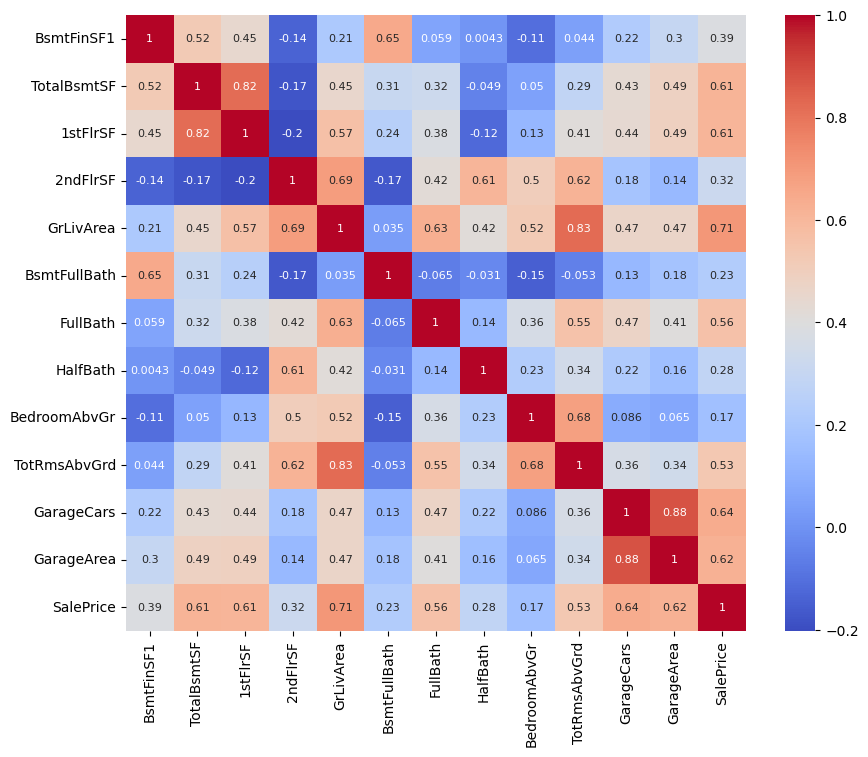

In [1483]:
# Compute correlation matrix
corr_matrix = df_train[num_cols].corr()

# Set threshold
threshold = 0.6

# Create a list of columns to keep
cols_to_keep = []
for col in corr_matrix.columns:
    if ((np.abs(corr_matrix[col]) > threshold) & (np.abs(corr_matrix[col]) != 1.0)).any():
        cols_to_keep.append(col)

# Create new correlation matrix with only the selected columns
corr_matrix_subset = corr_matrix.loc[cols_to_keep, cols_to_keep]

# Increase the size of the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(corr_matrix_subset, annot=True, cmap='coolwarm', ax=ax, annot_kws={"fontsize":8})

#### Removing columns with multicolinearity and keeping the higher correlation with SalePrice
- BsmtFinSF1 vs Bsmtfullbath: Highest correlation with SalePrice is BsmtFinSF1
- TotalBsmtSF vs 1stFlrSF: Equal correlation with SalePrice. Dropping 1stFlrSF
- 2ndFlrSF vs GrLivArea: Highest correlation with SalePrice is GrLivArea. Dropping 2ndFlrSF
- GrLivArea vs FullBath: Highest correlation with SalePrice is GrLivArea. Dropping FullBath
- BedroomAbvGr vs TotRmsAbvGrd: Highest correlation with SalePrice is TotRmsAbvGrd. Dropping BedroomAbvGr
- GarageCars vs GarageArea: Highest correlation with SalePrice is GarageCars. Dropping GarageArea

In [1484]:
multicorr_to_drop = ['BsmtFullBath', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'GarageArea']

### Model 1 - The naive one
Starting off with a naive model that uses a maximum of features. This model will act as a benchmark down the line.

In [1485]:
# Preparing data to be fitted. Isolating target variable.


y_train = df_train['SalePrice']
df_train = df_train.drop(multicorr_to_drop, axis=1)
X_train = df_train.drop('SalePrice', axis=1)
X_test = df_test.drop(multicorr_to_drop, axis=1)


In [1486]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1201 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   Neighborhood   1460 non-null   object 
 3   Condition1     1460 non-null   object 
 4   Condition2     1460 non-null   object 
 5   HouseStyle     1460 non-null   object 
 6   OverallQual    1460 non-null   object 
 7   OverallCond    1460 non-null   object 
 8   RoofMatl       1460 non-null   object 
 9   Exterior1st    1460 non-null   object 
 10  Exterior2nd    1460 non-null   object 
 11  MasVnrArea     1452 non-null   float64
 12  BsmtFinSF1     1460 non-null   int64  
 13  BsmtFinSF2     1460 non-null   int64  
 14  BsmtUnfSF      1460 non-null   int64  
 15  TotalBsmtSF    1460 non-null   int64  
 16  LowQualFinSF   1460 non-null   int64  
 17  GrLivArea      1460 non-null   int64  
 18  BsmtHalf

In [1487]:
# Updating cat and num col names variables. We'll use this to speed up imputation.

cat_cols = list(X_train.select_dtypes(include = ['object']))
num_cols = list(X_train.select_dtypes(exclude = ['object']))

In [1488]:
# Splitting up our data temporarily for imputation.

X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]

X_test_num = X_test[num_cols]
X_test_cat = X_test[cat_cols]

### Data imputation

#### Numerical features
The median will be used for imputing numerical features missing values to minimize effect of extreme values.

In [1489]:
# Storing indexes into variables for easier reassignment.
index_train = X_train.index
index_test = X_test.index

In [1490]:
# Finding the median in X_train using SimpleImputer.
imp_num = SimpleImputer(strategy = "median").fit(X_train_num)

# Replacing missing values with X_train's median.
X_train_num = imp_num.transform(X_train_num)
X_test_num = imp_num.transform(X_test_num)

# Converting arrays back into dataframes and reassigning indexes.
X_train_num = pd.DataFrame(X_train_num, columns = num_cols, index = index_train)
X_test_num = pd.DataFrame(X_test_num, columns = num_cols, index = index_test)

#### Categorical features
The mode will be used to impute categorical features

In [1491]:
# Finding the mode in X_train using SimpleImputer.
imp_cat = SimpleImputer(strategy = "most_frequent").fit(X_train_cat)

# Replacing missing values with X_train's mode.
X_train_cat = imp_cat.transform(X_train_cat)
X_test_cat = imp_cat.transform(X_test_cat)

# Converting arrays back into dataframes and reassigning indexes.
X_train_cat = pd.DataFrame(X_train_cat, columns = cat_cols, index = index_train)
X_test_cat = pd.DataFrame(X_test_cat, columns = cat_cols, index = index_test)

In [1492]:
# Concatenating numerical and categorical features back together.
X_train = pd.concat([X_train_num, X_train_cat], axis = 1)
X_test = pd.concat([X_test_num, X_test_cat], axis = 1)

#### Encoding categorical variables into binary features

In [1493]:
columnTransformer = ColumnTransformer(transformers = [("encoder", OneHotEncoder(), cat_cols)], remainder = "passthrough")

In [1494]:
X_train = pd.DataFrame(columnTransformer.fit_transform(X_train).toarray(), columns = columnTransformer.get_feature_names_out(), index=index_train)
X_test = pd.DataFrame(columnTransformer.transform(X_test).toarray(), columns = columnTransformer.get_feature_names_out(), index=index_test)

#### Scaling features
Using Robustscaler as we have a lot of features and it handles extreme values better.

In [1495]:
# Saving column names
X_cols = X_train.columns

# Scaling
rs = RobustScaler()
X_train = rs.fit_transform(X_train)
X_test = rs.transform(X_test)

# Converting back into pd dataframes.
X_train = pd.DataFrame(X_train, columns = X_cols, index = index_train)
X_test = pd.DataFrame(X_test, columns = X_cols, index = index_test)

#### Fitting model 1

In [1496]:
# Fitting model
lin_reg = LinearRegression().fit(X_train, y_train)

# Predicting on X_test
y_pred = lin_reg.predict(X_test)

In [1497]:
y_pred

array([114115.22965545, 171927.67088853, 189672.09404097, ...,
       192619.76833726, 110801.43883636, 212009.05660098])

In [1498]:
y_pred = pd.DataFrame(y_pred, columns = ['SalePrice'], index = index_test)

In [1499]:
y_pred

,SalePrice
Id,
1461,114115.229655
1462,171927.670889
1463,189672.094041
1464,196181.647163
1465,227351.397514
...,...
2915,87613.758576
2916,86493.155920
2917,192619.768337


In [1500]:
y_pred.to_csv('house_price_submission_kaggle.csv')

### Model 2 - Only numericals
Trying a second model only using numerical values. The hypothesis is that there are too many categorical features for the model to remain accurate.

In [1501]:
# Preparing data to be fitted. Isolating target variable.

y_train = df_train['SalePrice']
X_train = df_train.drop('SalePrice', axis=1)
X_test = df_test.drop(multicorr_to_drop, axis=1)

In [1502]:
# Updating cat and num col names variables. We'll use this to speed up imputation.

cat_cols = list(X_train.select_dtypes(include = ['object']))
num_cols = list(X_train.select_dtypes(exclude = ['object']))

In [1503]:
# Splitting up our data temporarily for imputation.

X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]

X_test_num = X_test[num_cols]
X_test_cat = X_test[cat_cols]

### Data imputation

#### Numerical features
The median will be used for imputing numerical features missing values to minimize effect of extreme values.

In [1504]:
# Storing indexes into variables for easier reassignment.
index_train = X_train.index
index_test = X_test.index

In [1505]:
# Finding the median in X_train using SimpleImputer.
imp_num = SimpleImputer(strategy = "median").fit(X_train_num)

# Replacing missing values with X_train's median.
X_train_num = imp_num.transform(X_train_num)
X_test_num = imp_num.transform(X_test_num)

# Converting arrays back into dataframes and reassigning indexes.
X_train_num = pd.DataFrame(X_train_num, columns = num_cols, index = index_train)
X_test_num = pd.DataFrame(X_test_num, columns = num_cols, index = index_test)

In [1506]:
# Assigning only numerical features to train and test
X_train = X_train_num
X_test = X_test_num

#### Scaling features
Using Robustscaler as we have a lot of features and it handles extreme values better.

In [1507]:
# Saving column names
X_cols = X_train.columns

# Scaling
rs = RobustScaler()
X_train = rs.fit_transform(X_train)
X_test = rs.transform(X_test)

# Converting back into pd dataframes.
X_train = pd.DataFrame(X_train, columns = X_cols, index = index_train)
X_test = pd.DataFrame(X_test, columns = X_cols, index = index_test)

#### Fitting model 2

In [1508]:
# Fitting model
lin_reg_2 = LinearRegression().fit(X_train, y_train)

# Predicting on X_test
y_pred_2 = lin_reg_2.predict(X_test)

In [1509]:
y_pred_2

array([110208.25989761, 167723.6411711 , 207732.19342865, ...,
       189842.02109456,  96936.02608855, 258772.7503382 ])

In [1510]:
y_pred_2 = pd.DataFrame(y_pred_2, columns = ['SalePrice'], index = index_test)

In [1511]:
y_pred_2

,SalePrice
Id,
1461,110208.259898
1462,167723.641171
1463,207732.193429
1464,210880.757219
1465,176939.130570
...,...
2915,82193.273547
2916,103897.666029
2917,189842.021095


In [1512]:
y_pred_2.to_csv('house_price_submission_kaggle.csv')